In [ ]:
import copy
import importlib
import os
import warnings
from itertools import product

import numpy as np
import torch
from dotenv import load_dotenv
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.tuner import Tuner
from tqdm.auto import tqdm

load_dotenv("../env")

warnings.filterwarnings("ignore", ".*does not have many workers.*")

In [2]:
import luminar.document.data
import luminar.document.model
import luminar.features
import luminar.mongo

importlib.reload(luminar.document.data)
importlib.reload(luminar.document.model)
importlib.reload(luminar.features)
importlib.reload(luminar.mongo)

<module 'luminar.mongo' from '/nvme/projects/PrismAI/PrismAI/src/luminar/mongo.py'>

In [3]:
from luminar.document.data import (
    DocumentClassificationDataModule,
    FeatureDataset,
    PaddingDataloader,
    n_way_split,
)
from luminar.document.model import ConvolutionalLayerSpec, DocumentClassficationModel
from luminar.features import FeatureExtractor, OneDimFeatures, Slicer, TwoDimFeatures
from luminar.mongo import PrismaiDataset

In [4]:
domains = {
    "Blog Authorship": {"domain": "blog_authorship_corpus"},
    "Student Essays": {"domain": "student_essays"},
    "CNN News": {"domain": "cnn_news"},
    "Euro Court Cases": {"domain": "euro_court_cases"},
    "House of Commons": {"domain": "house_of_commons"},
    "ArXiv Papers": {"domain": "arxiv_papers"},
    "Gutenberg": {"domain": "gutenberg", "lang": "en-EN"},
    "Bundestag [DE]": {"domain": "bundestag"},
    "Spiegel [DE]": {"domain": "spiegel_articles"},
    # "Gutenberg [DE]": {"domain": "gutenberg", "lang": "de-DE"},
}

In [5]:
dmap = {
    "Blog Authorship": "Blog Authorship",
    "Student Essays": "Student Essays",
    "CNN News": "CNN News",
    "Euro Court Cases": "Euro Court Cases",
    "House of Commons": "House of Commons",
    "ArXiv Papers": "ArXiv Papers",
    "Gutenberg [EN]": "Gutenberg",
    "Bundestag": "Bundestag [DE]",
    "Spiegel": "Spiegel [DE]",
    # "Gutenberg [DE]": 
}

In [6]:
config = {
    "seed": 1337,
    "eval_split": 0.1,
    "test_split": 0.1,
    "feature_model": "gpt2",
    "synth_agent": "gpt-4o-mini",
    # "synth_agent": "gemma2:9b"
}

In [7]:
datasets = {
    domain: PrismaiDataset(
        mongo_db_connection=os.environ.get("MONGO_DB_CONNECTION"),
        database="prismai",
        collection="features_prismai",
        feature_model=config["feature_model"],
        synth_agent=config["synth_agent"],
        **kwargs,
    )
    for domain, kwargs in domains.items()
}

In [8]:
train_splits = {}
eval_splits = {}
test_splits = {}
for domain, dataset in datasets.items():
    seed_everything(config["seed"])
    train_dataset, eval_dataset, test_dataset = n_way_split(
        dataset,
        config["eval_split"],
        config["test_split"],
        infer_first=True,
    )
    train_splits[domain] = train_dataset
    eval_splits[domain] = eval_dataset
    test_splits[domain] = test_dataset

Seed set to 1337


[PrismaiDataset] Loading Data from Cache File /nvme/.cache/luminar/ef0bf4ac00353b4c3cf35f1d81719f7c755a0aa74285110bc6d705aeab0f4275.pkl


Seed set to 1337


[PrismaiDataset] Loading Data from Cache File /nvme/.cache/luminar/5486290edc393c9f30480a59dd534ea751ae8a31b48bfd03b5f098c4f8bdc1cc.pkl


Seed set to 1337


[PrismaiDataset] Loading Data from Cache File /nvme/.cache/luminar/2982044d5332b295e5e8e3a5a6291d2757ee5843d7d6cbba05f6a53d57500b50.pkl


Seed set to 1337


[PrismaiDataset] Loading Data from Cache File /nvme/.cache/luminar/22643d0366260c134eb83cdacb95ab8caf23fbaf0150d3f2f7ae2cea07101987.pkl


Seed set to 1337


[PrismaiDataset] Loading Data from Cache File /nvme/.cache/luminar/1725afa23038757da3571b5b33d988ce03bef64b78aa936623b059be17e4b941.pkl


Seed set to 1337


[PrismaiDataset] Loading Data from Cache File /nvme/.cache/luminar/cf046e8f2421ad8948f68de42e767365337f656a51ce9f9bf2a508f41d1e99db.pkl


Seed set to 1337


[PrismaiDataset] Loading Data from Cache File /nvme/.cache/luminar/f38cb33ea5c3f40856a4db07115946d7a99c95fca0b54ce148415fb5063be266.pkl


Seed set to 1337


[PrismaiDataset] Loading Data from Cache File /nvme/.cache/luminar/281b270f73261fde5b5517abe476f7282592e6e4c0c4161857d3fd83c33aaf9b.pkl


Seed set to 1337


[PrismaiDataset] Loading Data from Cache File /nvme/.cache/luminar/50f2f9ce260cd153c5bca0c86708073a7221aad4c39b121601fdbb01dc3e6d31.pkl


## LLR


In [72]:
from luminar.baselines import llr_from_transition_scores
from simple_dataset import Dataset as SimpleDataset
from transition_scores.data import TransitionScores


def precompute_llr(split: list[dict]):
    lrr_dataset = (
        SimpleDataset(split)
        .flat_map(lambda doc: doc["features"])
        .map(
            lambda x: {
                "llr": llr_from_transition_scores(
                    TransitionScores(**x["transition_scores"])
                ),
                "labels": int(x["type"] != "source"),
            },
            in_place=False,
        )
    )

    llr = np.array(lrr_dataset["llr"])
    labels = np.array(lrr_dataset["labels"])

    return {"llr": llr, "labels": labels}


In [73]:
import pandas as pd
from sklearn.metrics import auc, roc_curve


def llr_metrics(llr: np.ndarray, labels: np.ndarray):
    mean_0 = float(np.mean(llr[labels == 0]))
    mean_1 = float(np.mean(llr[labels == 1]))
    threshold_simple = mean_0 + (mean_1 - mean_0) / 2
    acc_simple = np.mean((llr > threshold_simple) == labels)

    # thresholds = np.linspace(round(mean_0, 1) - 0.2, round(mean_1, 1) + 0.3, 1001)

    threshold_space = np.linspace(llr.min(), llr.max(), 10001)
    preds_thresholded: np.ndarray = llr > threshold_space.reshape(-1, 1)
    acc_thresholded = np.mean((preds_thresholded == labels), axis=1)
    idx = np.argmax(acc_thresholded)
    threshold_best = threshold_space[idx]
    acc_best = acc_thresholded[idx]

    fpr, tpr, _ = roc_curve(labels, llr)
    auroc = auc(fpr, tpr)

    return {
        "acc_simple": acc_simple,
        "threshold_simple": threshold_simple,
        "acc_best": acc_best,
        "threshold_best": threshold_best,
        "auroc": auroc,
    }


### LLR on Whole Datasets

In [74]:
llr_datasets = {}
for domain, dataset in tqdm(datasets.items()):
    llr_datasets[domain] = precompute_llr(dataset)

  0%|          | 0/9 [00:00<?, ?it/s]

In [75]:
results_llr = []
for domain, split in llr_datasets.items():
    results_llr.append({"domain": domain} | llr_metrics(split["llr"], split["labels"]))

pd.DataFrame(results_llr)

,domain,acc_simple,threshold_simple,acc_best,threshold_best,auroc
0,Blog Authorship,0.504020,1.856577,0.548246,2.927292,0.469396
1,Student Essays,0.769667,1.990933,0.780333,1.975895,0.845398
2,CNN News,0.878333,1.994945,0.879000,1.993035,0.941183
3,Euro Court Cases,0.851753,2.047082,0.855092,2.051046,0.914577
4,House of Commons,0.836577,1.973144,0.852013,1.981523,0.855806
5,ArXiv Papers,0.940000,1.913688,0.940333,1.908010,0.965488
6,Gutenberg,0.842615,1.924459,0.845036,1.926097,0.902650
7,Bundestag [DE],0.777133,1.786557,0.783276,1.789739,0.843577
8,Spiegel [DE],0.809746,1.757362,0.812083,1.758024,0.866562


### LLR on Test Splits

In [76]:
llr_test_datasets = {}
for domain, test_dataset in tqdm(test_splits.items()):
    llr_test_datasets[domain] = precompute_llr(test_dataset)

  0%|          | 0/9 [00:00<?, ?it/s]

In [77]:
results_test_llr = []
for domain, split in llr_test_datasets.items():
    results_test_llr.append(
        {"domain": domain} | llr_metrics(split["llr"], split["labels"])
    )

pd.DataFrame(results_test_llr)

,domain,acc_simple,threshold_simple,acc_best,threshold_best,auroc
0,Blog Authorship,0.462898,1.844718,0.530035,1.911967,0.442306
1,Student Essays,0.786667,1.989013,0.790000,1.974502,0.850044
2,CNN News,0.860000,1.992728,0.880000,1.979858,0.931244
3,Euro Court Cases,0.833333,2.053451,0.856667,2.072896,0.916222
4,House of Commons,0.838926,1.974758,0.852349,1.992164,0.853063
5,ArXiv Papers,0.924915,1.916540,0.928328,1.916780,0.953639
6,Gutenberg,0.841924,1.918735,0.848797,1.913750,0.886903
7,Bundestag [DE],0.752577,1.787583,0.780069,1.796051,0.818272
8,Spiegel [DE],0.779264,1.754643,0.792642,1.745569,0.858389


## Features

In [104]:
# feature_dim = OneDimFeatures(256)
# featurizer = FeatureExtractor.Likelihood()
# featurizer = FeatureExtractor.LogLikelihoodLogRankRatio()
# config["second_dim_as_channels"] = False
feature_dim = TwoDimFeatures(256, 16)
featurizer = FeatureExtractor.LikelihoodTopkLikelihoodRatio(16)
# featurizer = FeatureExtractor.IntermediateLogits(13)
# config["second_dim_as_channels"] = False
config["second_dim_as_channels"] = True

# slicer = Slicer.Random(feature_dim[0])
slicer = Slicer.RandomMultiple(feature_dim[0] // 4, multiple=4, stride=16)
# slicer = Slicer.RandomMultiple(feature_dim[0] // 4, 4)

config["feature_dim"] = feature_dim
config["featurizer"] = repr(featurizer)
config["slicer"] = repr(slicer)

config["num_samples"] = None


def featurize(dataset) -> FeatureDataset:
    return FeatureDataset(
        tqdm(dataset, position=1, leave=False),
        slicer,
        featurizer,
        num_samples=config["num_samples"],
    )

In [105]:
train_datasets, eval_datasets, test_datasets = {}, {}, {}
for domain, dataset in tqdm(datasets.items()):
    train_datasets[domain] = featurize(train_splits[domain])
    eval_datasets[domain] = featurize(eval_splits[domain])
    test_datasets[domain] = featurize(test_splits[domain])

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/1304 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/1194 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

## In-Domain Training & Evaluation

In [106]:
config |= {
    "projection_dim": None,
    "learning_rate": 0.0001,
    "warmup_steps": 69,
    "max_epochs": 50,
    "gradient_clip_val": 1.0,
    "batch_size": 32,
}

# SeqXGPT Layer Configuration
config["conv_layer_shapes"] = [
    ConvolutionalLayerSpec(64, 5),
    *[ConvolutionalLayerSpec(128, 3)] * 3,
    ConvolutionalLayerSpec(64, 3),
]

In [107]:
from torch.utils.data import ConcatDataset


# capturing config from "closure"
def get_dataloader(*dataset, **kwargs) -> PaddingDataloader:
    if len(dataset) == 1:
        dataset = dataset[0]
    else:
        dataset = ConcatDataset(dataset)
    return PaddingDataloader(
        dataset,
        feature_dim=config["feature_dim"],
        batch_size=config["batch_size"],
        **kwargs,
    )

In [108]:
results_in_domain = {}
for domain in domains:
    seed_everything(config["seed"])

    train_dataloader = get_dataloader(train_datasets[domain], shuffle=True)
    eval_dataloader = get_dataloader(eval_datasets[domain])

    model = DocumentClassficationModel(**config)
    trainer = Trainer(
        max_epochs=config["max_epochs"],
        logger=pl_loggers.TensorBoardLogger(
            save_dir=f"logs/in_domain/{type(featurizer).__name__}",
            name=domain,
        ),
        gradient_clip_val=config["gradient_clip_val"],
        callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=3)],
        deterministic=True,
    )

    trainer.fit(
        model,
        train_dataloaders=train_dataloader,
        val_dataloaders=eval_dataloader,
    )

    trainer.progress_bar_callback.disable()
    metrics = []
    for other, dataset in test_datasets.items():
        trainer.validate(model, get_dataloader(eval_datasets[other]), verbose=False)
        metrics.append(
            {
                "other": other,
            }
            | trainer.test(
                model,
                get_dataloader(dataset),
                verbose=False,
            )[0]
        )
    trainer.progress_bar_callback.enable()

    results_in_domain[domain] = {
        "domain": domain,
        "config": copy.deepcopy(config),
        "metrics": metrics,
    }
    print(domain, metrics)


Seed set to 1337
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'feature_dim' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['feature_dim'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
--------------------------------------------------------------------------------------
0 | conv_layers | Sequential        | 153 K  | train | ?           | ?          
1 | projection  | Identity          | 0      | train | [32, 16384] | [32, 16384]
2 | classifier  | Linear            | 16.4 K | train | [32, 16384] | [32, 1]    
3 | criterion   | BCEWithLogitsLoss | 0      | train | ?   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Seed set to 1337


Blog Authorship [{'other': 'Blog Authorship', 'test_loss': 0.18298836052417755, 'test_acc@0.5': 0.9081271886825562, 'test_acc@best': 0.8975265026092529, 'test_roc_auc': 0.9840100407600403}, {'other': 'Student Essays', 'test_loss': 1.5315074920654297, 'test_acc@0.5': 0.5433333516120911, 'test_acc@best': 0.6000000238418579, 'test_roc_auc': 0.6339111328125}, {'other': 'CNN News', 'test_loss': 1.596932291984558, 'test_acc@0.5': 0.5866666436195374, 'test_acc@best': 0.6133333444595337, 'test_roc_auc': 0.6770889163017273}, {'other': 'Euro Court Cases', 'test_loss': 2.4005837440490723, 'test_acc@0.5': 0.5166666507720947, 'test_acc@best': 0.5133333206176758, 'test_roc_auc': 0.5323110818862915}, {'other': 'House of Commons', 'test_loss': 1.6015156507492065, 'test_acc@0.5': 0.5402684807777405, 'test_acc@best': 0.6241610646247864, 'test_roc_auc': 0.6634684801101685}, {'other': 'ArXiv Papers', 'test_loss': 1.9053095579147339, 'test_acc@0.5': 0.5631399154663086, 'test_acc@best': 0.5597269535064697, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'feature_dim' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['feature_dim'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
--------------------------------------------------------------------------------------
0 | conv_layers | Sequential        | 153 K  | train | ?           | ?          
1 | projection  | Identity          | 0      | train | [32, 16384] | [32, 16384]
2 | classifier  | Linear            | 16.4 K | train | [32, 16384] | [32, 1]    
3 | criterion   | BCEWithLogitsLoss | 0      | train | ?           | ?      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Seed set to 1337


Student Essays [{'other': 'Blog Authorship', 'test_loss': 5.719544410705566, 'test_acc@0.5': 0.583038866519928, 'test_acc@best': 0.5901060104370117, 'test_roc_auc': 0.49593985080718994}, {'other': 'Student Essays', 'test_loss': 0.26252278685569763, 'test_acc@0.5': 0.8866666555404663, 'test_acc@best': 0.8866666555404663, 'test_roc_auc': 0.9588000178337097}, {'other': 'CNN News', 'test_loss': 0.4370354115962982, 'test_acc@0.5': 0.8033333420753479, 'test_acc@best': 0.8633333444595337, 'test_roc_auc': 0.9435999989509583}, {'other': 'Euro Court Cases', 'test_loss': 1.332879900932312, 'test_acc@0.5': 0.6033333539962769, 'test_acc@best': 0.753333330154419, 'test_roc_auc': 0.8285777568817139}, {'other': 'House of Commons', 'test_loss': 1.5110257863998413, 'test_acc@0.5': 0.7986577153205872, 'test_acc@best': 0.8288590312004089, 'test_roc_auc': 0.8049549460411072}, {'other': 'ArXiv Papers', 'test_loss': 1.3275880813598633, 'test_acc@0.5': 0.80887371301651, 'test_acc@best': 0.8327645063400269, 't

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'feature_dim' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['feature_dim'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
--------------------------------------------------------------------------------------
0 | conv_layers | Sequential        | 153 K  | train | ?           | ?          
1 | projection  | Identity          | 0      | train | [32, 16384] | [32, 16384]
2 | classifier  | Linear            | 16.4 K | train | [32, 16384] | [32, 1]    
3 | criterion   | BCEWithLogitsLoss | 0      | train | ?           | ?      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Seed set to 1337


CNN News [{'other': 'Blog Authorship', 'test_loss': 1.356467604637146, 'test_acc@0.5': 0.5689045786857605, 'test_acc@best': 0.565371036529541, 'test_roc_auc': 0.5229573845863342}, {'other': 'Student Essays', 'test_loss': 0.38005468249320984, 'test_acc@0.5': 0.8399999737739563, 'test_acc@best': 0.8433333039283752, 'test_roc_auc': 0.9168000221252441}, {'other': 'CNN News', 'test_loss': 0.499676913022995, 'test_acc@0.5': 0.800000011920929, 'test_acc@best': 0.8533333539962769, 'test_roc_auc': 0.92448890209198}, {'other': 'Euro Court Cases', 'test_loss': 1.0921038389205933, 'test_acc@0.5': 0.5799999833106995, 'test_acc@best': 0.7200000286102295, 'test_roc_auc': 0.7957333326339722}, {'other': 'House of Commons', 'test_loss': 0.4750765860080719, 'test_acc@0.5': 0.7684563994407654, 'test_acc@best': 0.8422818779945374, 'test_roc_auc': 0.8600450158119202}, {'other': 'ArXiv Papers', 'test_loss': 0.33163899183273315, 'test_acc@0.5': 0.849829375743866, 'test_acc@best': 0.8532423377037048, 'test_roc

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'feature_dim' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['feature_dim'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
--------------------------------------------------------------------------------------
0 | conv_layers | Sequential        | 153 K  | train | ?           | ?          
1 | projection  | Identity          | 0      | train | [32, 16384] | [32, 16384]
2 | classifier  | Linear            | 16.4 K | train | [32, 16384] | [32, 1]    
3 | criterion   | BCEWithLogitsLoss | 0      | train | ?           | ?      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Seed set to 1337


Euro Court Cases [{'other': 'Blog Authorship', 'test_loss': 1.655446171760559, 'test_acc@0.5': 0.49823322892189026, 'test_acc@best': 0.5300353169441223, 'test_roc_auc': 0.5076190233230591}, {'other': 'Student Essays', 'test_loss': 0.850621223449707, 'test_acc@0.5': 0.6000000238418579, 'test_acc@best': 0.8399999737739563, 'test_roc_auc': 0.9079999923706055}, {'other': 'CNN News', 'test_loss': 0.5861331224441528, 'test_acc@0.5': 0.7066666483879089, 'test_acc@best': 0.8266666531562805, 'test_roc_auc': 0.9176444411277771}, {'other': 'Euro Court Cases', 'test_loss': 0.5176822543144226, 'test_acc@0.5': 0.7433333396911621, 'test_acc@best': 0.7333333492279053, 'test_roc_auc': 0.8338666558265686}, {'other': 'House of Commons', 'test_loss': 0.5528303980827332, 'test_acc@0.5': 0.7651006579399109, 'test_acc@best': 0.8825503587722778, 'test_roc_auc': 0.9074774980545044}, {'other': 'ArXiv Papers', 'test_loss': 0.6028715968132019, 'test_acc@0.5': 0.723549485206604, 'test_acc@best': 0.9283276200294495

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'feature_dim' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['feature_dim'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
--------------------------------------------------------------------------------------
0 | conv_layers | Sequential        | 153 K  | train | ?           | ?          
1 | projection  | Identity          | 0      | train | [32, 16384] | [32, 16384]
2 | classifier  | Linear            | 16.4 K | train | [32, 16384] | [32, 1]    
3 | criterion   | BCEWithLogitsLoss | 0      | train | ?           | ?      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Seed set to 1337


House of Commons [{'other': 'Blog Authorship', 'test_loss': 1.5660959482192993, 'test_acc@0.5': 0.49823322892189026, 'test_acc@best': 0.5335689187049866, 'test_roc_auc': 0.4866165518760681}, {'other': 'Student Essays', 'test_loss': 0.4131241738796234, 'test_acc@0.5': 0.8433333039283752, 'test_acc@best': 0.8333333134651184, 'test_roc_auc': 0.9148444533348083}, {'other': 'CNN News', 'test_loss': 0.5166752934455872, 'test_acc@0.5': 0.8100000023841858, 'test_acc@best': 0.8399999737739563, 'test_roc_auc': 0.9154222011566162}, {'other': 'Euro Court Cases', 'test_loss': 1.3253952264785767, 'test_acc@0.5': 0.6066666841506958, 'test_acc@best': 0.7266666889190674, 'test_roc_auc': 0.7940000295639038}, {'other': 'House of Commons', 'test_loss': 0.3026309311389923, 'test_acc@0.5': 0.8624160885810852, 'test_acc@best': 0.8825503587722778, 'test_roc_auc': 0.957927942276001}, {'other': 'ArXiv Papers', 'test_loss': 0.17992176115512848, 'test_acc@0.5': 0.9385665655136108, 'test_acc@best': 0.9385665655136

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'feature_dim' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['feature_dim'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
--------------------------------------------------------------------------------------
0 | conv_layers | Sequential        | 153 K  | train | ?           | ?          
1 | projection  | Identity          | 0      | train | [32, 16384] | [32, 16384]
2 | classifier  | Linear            | 16.4 K | train | [32, 16384] | [32, 1]    
3 | criterion   | BCEWithLogitsLoss | 0      | train | ?           | ?      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Seed set to 1337


ArXiv Papers [{'other': 'Blog Authorship', 'test_loss': 9.59347915649414, 'test_acc@0.5': 0.5159010887145996, 'test_acc@best': 0.5265017747879028, 'test_roc_auc': 0.5088220834732056}, {'other': 'Student Essays', 'test_loss': 0.6637491583824158, 'test_acc@0.5': 0.7933333516120911, 'test_acc@best': 0.8266666531562805, 'test_roc_auc': 0.9128444194793701}, {'other': 'CNN News', 'test_loss': 0.9587766528129578, 'test_acc@0.5': 0.7066666483879089, 'test_acc@best': 0.8233333230018616, 'test_roc_auc': 0.9120444655418396}, {'other': 'Euro Court Cases', 'test_loss': 1.8340733051300049, 'test_acc@0.5': 0.5666666626930237, 'test_acc@best': 0.746666669845581, 'test_roc_auc': 0.8180444240570068}, {'other': 'House of Commons', 'test_loss': 1.7641674280166626, 'test_acc@0.5': 0.7315436005592346, 'test_acc@best': 0.8859060406684875, 'test_roc_auc': 0.8921621441841125}, {'other': 'ArXiv Papers', 'test_loss': 0.16134177148342133, 'test_acc@0.5': 0.9419795274734497, 'test_acc@best': 0.9453924894332886, 't

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'feature_dim' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['feature_dim'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
--------------------------------------------------------------------------------------
0 | conv_layers | Sequential        | 153 K  | train | ?           | ?          
1 | projection  | Identity          | 0      | train | [32, 16384] | [32, 16384]
2 | classifier  | Linear            | 16.4 K | train | [32, 16384] | [32, 1]    
3 | criterion   | BCEWithLogitsLoss | 0      | train | ?           | ?      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Seed set to 1337


Gutenberg [{'other': 'Blog Authorship', 'test_loss': 1.5097944736480713, 'test_acc@0.5': 0.5159010887145996, 'test_acc@best': 0.5441696047782898, 'test_roc_auc': 0.4877694249153137}, {'other': 'Student Essays', 'test_loss': 0.37518152594566345, 'test_acc@0.5': 0.8299999833106995, 'test_acc@best': 0.8266666531562805, 'test_roc_auc': 0.9215555787086487}, {'other': 'CNN News', 'test_loss': 0.40968504548072815, 'test_acc@0.5': 0.8399999737739563, 'test_acc@best': 0.8333333134651184, 'test_roc_auc': 0.9211111068725586}, {'other': 'Euro Court Cases', 'test_loss': 0.9050071835517883, 'test_acc@0.5': 0.6433333158493042, 'test_acc@best': 0.7133333086967468, 'test_roc_auc': 0.8117333054542542}, {'other': 'House of Commons', 'test_loss': 0.3119862973690033, 'test_acc@0.5': 0.8859060406684875, 'test_acc@best': 0.9026845693588257, 'test_roc_auc': 0.9534684419631958}, {'other': 'ArXiv Papers', 'test_loss': 0.20895396173000336, 'test_acc@0.5': 0.9249146580696106, 'test_acc@best': 0.935153603553772, '

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'feature_dim' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['feature_dim'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
--------------------------------------------------------------------------------------
0 | conv_layers | Sequential        | 153 K  | train | ?           | ?          
1 | projection  | Identity          | 0      | train | [32, 16384] | [32, 16384]
2 | classifier  | Linear            | 16.4 K | train | [32, 16384] | [32, 1]    
3 | criterion   | BCEWithLogitsLoss | 0      | train | ?           | ?      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Seed set to 1337


Bundestag [DE] [{'other': 'Blog Authorship', 'test_loss': 0.9933467507362366, 'test_acc@0.5': 0.4911660850048065, 'test_acc@best': 0.5724381804466248, 'test_roc_auc': 0.43253132700920105}, {'other': 'Student Essays', 'test_loss': 1.5562576055526733, 'test_acc@0.5': 0.5266666412353516, 'test_acc@best': 0.8166666626930237, 'test_roc_auc': 0.8844444155693054}, {'other': 'CNN News', 'test_loss': 1.9345356225967407, 'test_acc@0.5': 0.5166666507720947, 'test_acc@best': 0.7833333611488342, 'test_roc_auc': 0.8609777688980103}, {'other': 'Euro Court Cases', 'test_loss': 2.4676873683929443, 'test_acc@0.5': 0.5, 'test_acc@best': 0.6866666674613953, 'test_roc_auc': 0.768666684627533}, {'other': 'House of Commons', 'test_loss': 1.6124229431152344, 'test_acc@0.5': 0.5033556818962097, 'test_acc@best': 0.8020133972167969, 'test_roc_auc': 0.8000900745391846}, {'other': 'ArXiv Papers', 'test_loss': 1.1475695371627808, 'test_acc@0.5': 0.5665528774261475, 'test_acc@best': 0.8191125988960266, 'test_roc_auc

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'feature_dim' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['feature_dim'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
--------------------------------------------------------------------------------------
0 | conv_layers | Sequential        | 153 K  | train | ?           | ?          
1 | projection  | Identity          | 0      | train | [32, 16384] | [32, 16384]
2 | classifier  | Linear            | 16.4 K | train | [32, 16384] | [32, 1]    
3 | criterion   | BCEWithLogitsLoss | 0      | train | ?           | ?      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Spiegel [DE] [{'other': 'Blog Authorship', 'test_loss': 1.3505350351333618, 'test_acc@0.5': 0.5265017747879028, 'test_acc@best': 0.565371036529541, 'test_roc_auc': 0.40987467765808105}, {'other': 'Student Essays', 'test_loss': 1.8062877655029297, 'test_acc@0.5': 0.5199999809265137, 'test_acc@best': 0.8266666531562805, 'test_roc_auc': 0.8865333199501038}, {'other': 'CNN News', 'test_loss': 2.1506502628326416, 'test_acc@0.5': 0.503333330154419, 'test_acc@best': 0.8066666722297668, 'test_roc_auc': 0.8616889119148254}, {'other': 'Euro Court Cases', 'test_loss': 2.7483460903167725, 'test_acc@0.5': 0.4866666793823242, 'test_acc@best': 0.6833333373069763, 'test_roc_auc': 0.7566666603088379}, {'other': 'House of Commons', 'test_loss': 2.014195680618286, 'test_acc@0.5': 0.4563758373260498, 'test_acc@best': 0.8120805621147156, 'test_roc_auc': 0.7945045232772827}, {'other': 'ArXiv Papers', 'test_loss': 1.50626802444458, 'test_acc@0.5': 0.4505119323730469, 'test_acc@best': 0.849829375743866, 'test

In [109]:
import pandas as pd

results = []
for domain in domains:
    results.append(
        [results_in_domain[domain]["metrics"][i]["test_roc_auc"] for i in range(len(domains))]
    )

df = pd.DataFrame(results, columns=domains, index=domains)
df

,Blog Authorship,Student Essays,CNN News,Euro Court Cases,House of Commons,ArXiv Papers,Gutenberg,Bundestag [DE],Spiegel [DE]
Blog Authorship,0.984010,0.633911,0.677089,0.532311,0.663468,0.577789,0.724823,0.546885,0.675973
Student Essays,0.495940,0.958800,0.943600,0.828578,0.804955,0.809477,0.931678,0.757255,0.786622
CNN News,0.522957,0.916800,0.924489,0.795733,0.860045,0.929457,0.948038,0.746526,0.812752
Euro Court Cases,0.507619,0.908000,0.917644,0.833867,0.907477,0.979778,0.945910,0.766140,0.826532
House of Commons,0.486617,0.914844,0.915422,0.794000,0.957928,0.981456,0.953333,0.753994,0.817718
ArXiv Papers,0.508822,0.912844,0.912044,0.818044,0.892162,0.985835,0.953546,0.758011,0.823445
Gutenberg,0.487769,0.921556,0.921111,0.811733,0.953468,0.978380,0.957258,0.762312,0.826756
Bundestag [DE],0.432531,0.884444,0.860978,0.768667,0.800090,0.856723,0.912861,0.794026,0.849933
Spiegel [DE],0.409875,0.886533,0.861689,0.756667,0.794505,0.814276,0.899527,0.750780,0.859105


## Cross-Domain Training & Evaluation

In [110]:
seed_everything(config["seed"])
train_dataloader = get_dataloader(*train_datasets.values(), shuffle=True)
eval_dataloader = get_dataloader(*eval_datasets.values())
test_dataloader = get_dataloader(*test_datasets.values())

model = DocumentClassficationModel(**config)
trainer = Trainer(
    max_epochs=config["max_epochs"],
    logger=pl_loggers.TensorBoardLogger(
        save_dir=f"logs/all_domains/{type(featurizer).__name__}",
    ),
    gradient_clip_val=config["gradient_clip_val"],
    callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=3)],
    deterministic=True,
)
trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=eval_dataloader,
)

Seed set to 1337
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mastoeck/Projects/PrismAI/PrismAI/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'feature_dim' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['feature_dim'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name        | Type              | Params | Mode  | In sizes    | Out sizes  
--------------------------------------------------------------------------------------
0 | conv_layers | Sequential        | 153 K  | train | ?           | ?          
1 | projection  | Identity          | 0      | train | [32, 16384] | [32, 16384]
2 | classifier  | Linear            | 16.4 K | train | [32, 16384] | [32, 1]    
3 | criterion   | BCEWithLogitsLoss | 0      | train | ?   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [111]:
trainer.progress_bar_callback.disable()
metrics_cross_domain = []
for other, dataset in test_datasets.items():
    trainer.validate(model, get_dataloader(eval_datasets[domain]), verbose=False)
    metrics_cross_domain.append(
        {"other": other}
        | trainer.test(model, get_dataloader(dataset), verbose=False)[0]
    )
trainer.validate(model, eval_dataloader, verbose=False)
metrics_cross_domain += [
    {
        "other": "ALL",
        **trainer.test(model, test_dataloader, verbose=False)[0],
    }
]
trainer.progress_bar_callback.enable()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [112]:
import pandas as pd


def df_to_latex_heatmap(_df: pd.DataFrame):
    print(
        "\\plotHeatmap{"
        + ",".join(_df.index)
        + "}{%\n    "
        + ",%\n    ".join(
            [
                "{"
                + ",".join(f"{val:.4f}/{round(val, 2):.2f}" for val in row[1:])
                + "}"
                for row in _df.reset_index().values
            ]
        )
        + "%\n}{"
        + ",".join(_df.columns)
        + "}"
    )


In [113]:
_metric = "test_roc_auc"
# _metric = "test_acc@best"

results = []
for domain in domains:
    results.append(
        [
            results_in_domain[domain]["metrics"][i][_metric]
            for i in range(len(domains))
        ]
    )
results.append([m[_metric] for m in metrics_cross_domain[:len(domains)]])

df = pd.DataFrame(results, columns=list(domains), index=list(domains) + ["ALL"])
df["AVG"] = df.mean(axis=1)
df["AVG"][-1] = metrics_cross_domain[-1][_metric]
df

/tmp/ipykernel_37285/3101317753.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["AVG"][-1] = metrics_cross_domain[-1][_metric]
/tmp/ipykernel_37285/3101317753.py:16: FutureWarning: Series.__setitem__ treating keys as positions is dep

,Blog Authorship,Student Essays,CNN News,Euro Court Cases,House of Commons,ArXiv Papers,Gutenberg,Bundestag [DE],Spiegel [DE],AVG
Blog Authorship,0.984010,0.633911,0.677089,0.532311,0.663468,0.577789,0.724823,0.546885,0.675973,0.668473
Student Essays,0.495940,0.958800,0.943600,0.828578,0.804955,0.809477,0.931678,0.757255,0.786622,0.812989
CNN News,0.522957,0.916800,0.924489,0.795733,0.860045,0.929457,0.948038,0.746526,0.812752,0.828533
Euro Court Cases,0.507619,0.908000,0.917644,0.833867,0.907477,0.979778,0.945910,0.766140,0.826532,0.843663
House of Commons,0.486617,0.914844,0.915422,0.794000,0.957928,0.981456,0.953333,0.753994,0.817718,0.841701
ArXiv Papers,0.508822,0.912844,0.912044,0.818044,0.892162,0.985835,0.953546,0.758011,0.823445,0.840528
Gutenberg,0.487769,0.921556,0.921111,0.811733,0.953468,0.978380,0.957258,0.762312,0.826756,0.846705
Bundestag [DE],0.432531,0.884444,0.860978,0.768667,0.800090,0.856723,0.912861,0.794026,0.849933,0.795584
Spiegel [DE],0.409875,0.886533,0.861689,0.756667,0.794505,0.814276,0.899527,0.750780,0.859105,0.781440
ALL,0.924411,0.947511,0.966711,0.859156,0.943514,0.963191,0.968227,0.778287,0.781521,0.900894


In [114]:
df_to_latex_heatmap(df)

\plotHeatmap{Blog Authorship,Student Essays,CNN News,Euro Court Cases,House of Commons,ArXiv Papers,Gutenberg,Bundestag [DE],Spiegel [DE],ALL}{%
    {0.9840/0.98,0.6339/0.63,0.6771/0.68,0.5323/0.53,0.6635/0.66,0.5778/0.58,0.7248/0.72,0.5469/0.55,0.6760/0.68,0.6685/0.67},%
    {0.4959/0.50,0.9588/0.96,0.9436/0.94,0.8286/0.83,0.8050/0.80,0.8095/0.81,0.9317/0.93,0.7573/0.76,0.7866/0.79,0.8130/0.81},%
    {0.5230/0.52,0.9168/0.92,0.9245/0.92,0.7957/0.80,0.8600/0.86,0.9295/0.93,0.9480/0.95,0.7465/0.75,0.8128/0.81,0.8285/0.83},%
    {0.5076/0.51,0.9080/0.91,0.9176/0.92,0.8339/0.83,0.9075/0.91,0.9798/0.98,0.9459/0.95,0.7661/0.77,0.8265/0.83,0.8437/0.84},%
    {0.4866/0.49,0.9148/0.91,0.9154/0.92,0.7940/0.79,0.9579/0.96,0.9815/0.98,0.9533/0.95,0.7540/0.75,0.8177/0.82,0.8417/0.84},%
    {0.5088/0.51,0.9128/0.91,0.9120/0.91,0.8180/0.82,0.8922/0.89,0.9858/0.99,0.9535/0.95,0.7580/0.76,0.8234/0.82,0.8405/0.84},%
    {0.4878/0.49,0.9216/0.92,0.9211/0.92,0.8117/0.81,0.9535/0.95,0.9784/0.98,0.9573/0.9

In [115]:
config

{'seed': 1337,
 'eval_split': 0.1,
 'test_split': 0.1,
 'feature_model': 'gpt2',
 'synth_agent': 'gpt-4o-mini',
 'second_dim_as_channels': True,
 'feature_dim': TwoDimFeatures(height=256, width=16),
 'featurizer': 'LikelihoodTopkLikelihoodRatio(top_k=16)',
 'slicer': 'SliceRandomMultiple(size=64, multiple=4, stride=16, sort=False)',
 'num_samples': None,
 'projection_dim': None,
 'learning_rate': 0.0001,
 'warmup_steps': 69,
 'max_epochs': 50,
 'gradient_clip_val': 1.0,
 'batch_size': 32,
 'conv_layer_shapes': [(64, 5, 1),
  (128, 3, 1),
  (128, 3, 1),
  (128, 3, 1),
  (64, 3, 1)]}

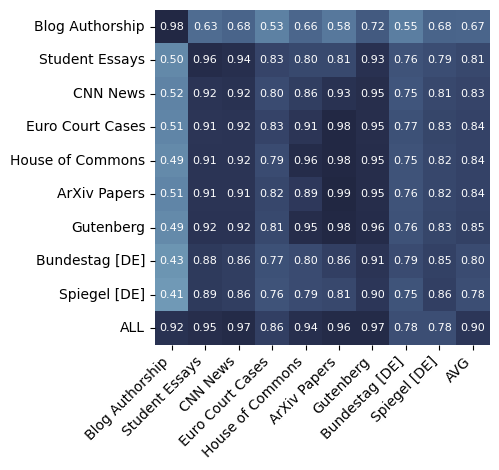

In [116]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

ax = sns.heatmap(
    df,
    annot=True,
    fmt=".2f",
    vmax=1.0,
    vmin=0.0,
    cmap=sns.cubehelix_palette(rot=-0.2, as_cmap=True),
    yticklabels=list(domains) + ["ALL"],
    xticklabels=list(domains) + ["AVG"],
    square=True,
    # reduce annotation font size
    annot_kws={"fontsize": 8},
    cbar=False,
)

# rotate x-axis labels by 45 degrees
# anchored at the right edge of the axes
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment("right")

plt.tight_layout()
# plt.savefig(
#     "../figures/evaluation-trained_in_domain-test_0.1-gpt2_256-rand_4-il_13_as_channels.pdf",
#     dpi=300,
# )
plt.show()

In [117]:
raise RuntimeError("Stop here.")

RuntimeError: Stop here.

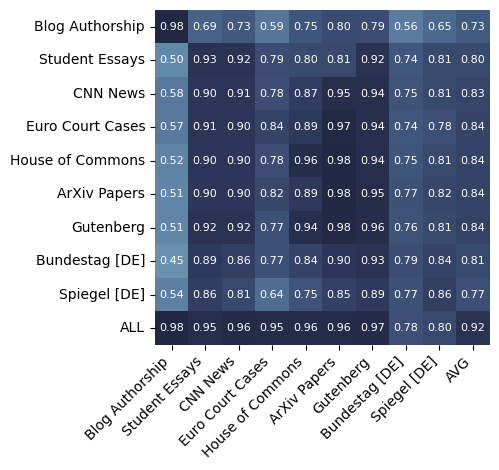

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

ax = sns.heatmap(
    df,
    annot=True,
    fmt=".2f",
    vmax=1.0,
    vmin=0.0,
    cmap=sns.cubehelix_palette(rot=-0.2, as_cmap=True),
    yticklabels=list(domains) + ["ALL"],
    xticklabels=list(domains) + ["AVG"],
    square=True,
    # reduce annotation font size
    annot_kws={"fontsize": 8},
    cbar=False,
)

# rotate x-axis labels by 45 degrees
# anchored at the right edge of the axes
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment("right")

plt.tight_layout()
# plt.savefig(
#     "../figures/evaluation-trained_in_domain-test_0.1-gpt2_256-rand_4-il_13_as_channels.pdf",
#     dpi=300,
# )
plt.show()